In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Funcion que cambia de espacio de color RGB a YIQ
def RGB_to_YIQ(rgb):
   yiq = np.zeros(rgb.shape)
   yiq[:,:,0] = 0.229*rgb[:,:,0] + 0.587*rgb[:,:,1] + 0.114*rgb[:,:,2]
   yiq[:,:,1] = 0.595716*rgb[:,:,0] - 0.274453*rgb[:,:,1] - 0.321263*rgb[:,:,2]
   yiq[:,:,2] = 0.211456*rgb[:,:,0] - 0.522591*rgb[:,:,1] + 0.311135*rgb[:,:,2]
   yiq[:,:,3]=rgb[:,:,3]
   return yiq

In [3]:
# Fuincion que cambia de espacio de color YIQ a RGB
def YIQ_to_RGB(yiq):
  rgb = np.zeros(yiq.shape)
  rgb[:,:,0] = yiq[:,:,0] + 0.9663*yiq[:,:,1] + 0.6210*yiq[:,:,2]
  rgb[:,:,1] = yiq[:,:,0] - 0.2721*yiq[:,:,1] - 0.6474*yiq[:,:,2]
  rgb[:,:,2] = yiq[:,:,0] - 1.1070*yiq[:,:,1] + 1.7046*yiq[:,:,2]
  rgb[:,:,3]=yiq[:,:,3]
  return rgb

In [26]:
def _convolution(image, kernel = np.ones((1,1)), option = 'sum'):
    convolved = np.zeros((np.array(image.shape)-np.array(kernel.shape)+1))
    if option == 'sum':
            for x in range(convolved.shape[0]):
                for y in range(convolved.shape[1]):
                    convolved[x,y] = (image[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).sum()
    if option == 'max':
            for x in range(convolved.shape[0]):
                for y in range(convolved.shape[1]):
                    convolved[x,y] = (image[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).max()      
    if option == 'min':
            for x in range(convolved.shape[0]):
                for y in range(convolved.shape[1]):
                    convolved[x,y] = (image[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).min()               
    return convolved

In [4]:
def im_dilate(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim <= 2:
        return _morph_op(img, se, np.max, 'minimum')
    else:
        return _yiq_morph_op(img, se, im_dilate)

def im_erode(img, se):
    '''Morphological erotion for binary, grayscale or RGB images.'''
    if img.ndim <= 2:
        if img.dtype == np.dtype('bool'):
            return _morph_op(img, se, np.min, 'minimum')
        else:
            return _morph_op(img, se, np.min, 'maximum')
    else:
        return _yiq_morph_op(img, se, im_erode)


### Convolucionando con Imágenes Binarias

In [ ]:
se = np.ones((3,3),bool)
print(se)

In [23]:
def im_dilate(image,se):
    dilated = _convolution(image,se,'min')
    return dilated

def im_erode(image,se):
    eroded = _convolution(image,se,'max')
    return eroded

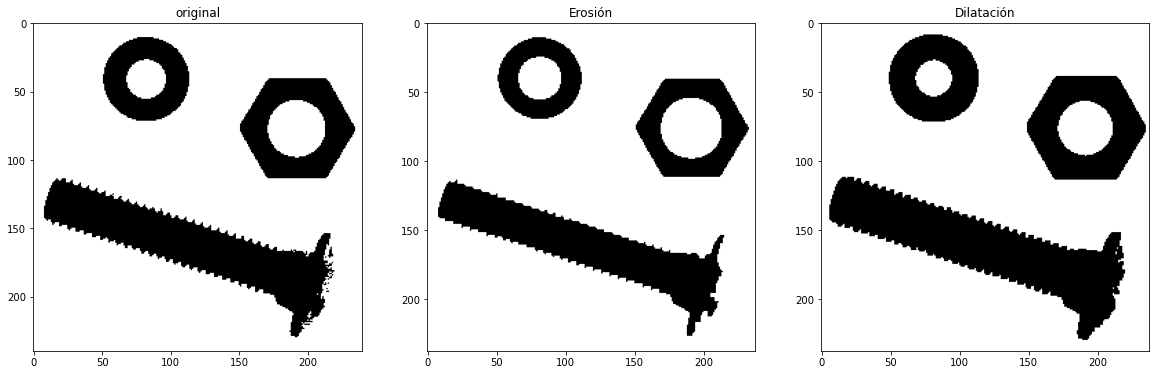

In [35]:
im=imageio.imread('f02bin.bmp')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20,20)
ax1.imshow(im,'gray')
ax1.set_title('original')
ax2.imshow(im_erode(im, se),'gray')
ax2.set_title('Erosión')
ax3.imshow(im_dilate(im, se),'gray')
ax3.set_title('Dilatación')
plt.show()

#### Morfología en escala de grises

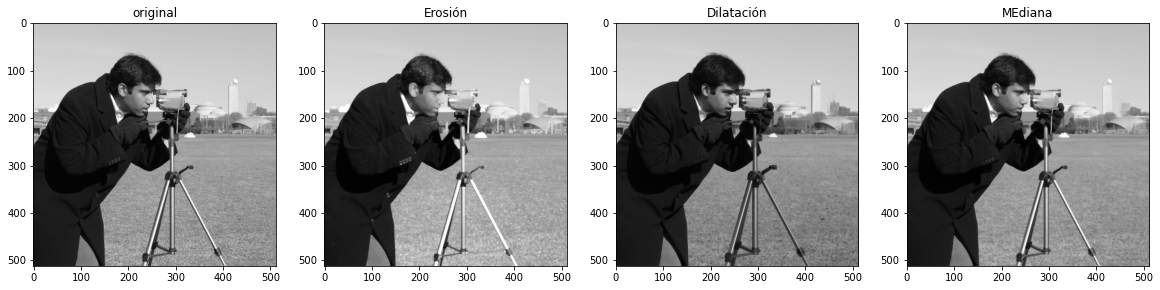

In [38]:
def _morph_gray(im, se, op):
    result = np.zeros(im.shape)
    offset = (np.array(se.shape)-1)//2
    im = np.pad(im,[(offset[0],offset[0]),(offset[1],offset[1])],'edge')
    for y, x in np.ndindex(result.shape):
        pixels = im[y: y + se.shape[0], x: x + se.shape[1]][se]
        result[y, x] = op(pixels)
    return result

im_g = imageio.imread('imageio:camera.png')/255.

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)
fig.set_size_inches(20,20)
ax1.imshow(im_g,'gray')
ax1.set_title('original')
ax2.imshow(_morph_gray(im_g, se, np.max), 'gray')
ax2.set_title('Erosión')
ax3.imshow(_morph_gray(im_g, se, np.min), 'gray')
ax3.set_title('Dilatación')
ax4.imshow(_morph_gray(im_g, se, np.median), 'gray')
ax4.set_title('MEdiana')
plt.show()

### Morfología en Colores

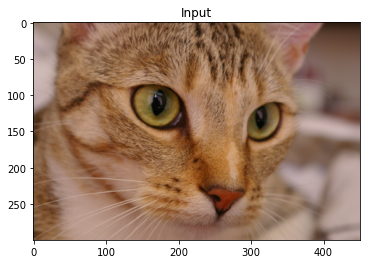

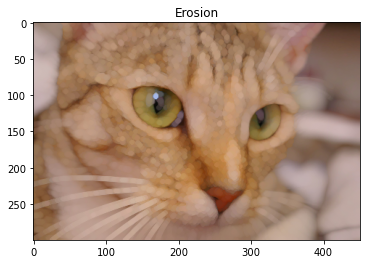

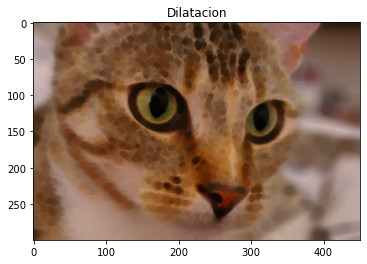

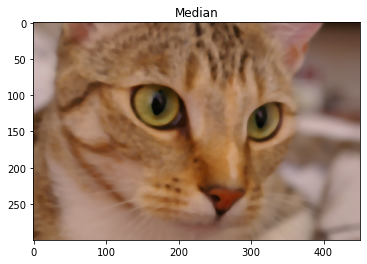

In [41]:
def box(r):
    se = np.ones((r*2+1,r*2+1),dtype=np.bool)
    return se

def circle(r, threshold = 0.3):
    vec = np.linspace(-r, r, r*2+1)
    [x,y] = np.meshgrid(vec,vec) 
    se = (x**2 + y**2)**0.5 < (r + threshold)
    return se

MAT_YIQ = np.array([[0.299, 0.595716, 0.211456],[0.587, -0.274453, -0.522591],[0.114, -0.321263, 0.311135]])

def rgb2yiq(_im):
    return (_im.reshape((-1, 3)) @ MAT_YIQ).reshape(_im.shape)

def yiq2rgb(_yiq):
    return (_yiq.reshape((-1, 3)) @ np.linalg.inv(MAT_YIQ)).reshape(_yiq.shape)

def _morph_multiband(im, se, op):
    result = np.zeros(im.shape)
    offset = (np.array(se.shape)-1)//2
    im = np.pad(im,[(offset[0],offset[0]),(offset[1],offset[1]),(0,0)],'edge')
    for y, x in np.ndindex(result.shape[:2]):
        pixels = im[y:y+se.shape[0], x:x+se.shape[1]][se]
        result[y, x] = pixels[op(pixels[:,0])]
    return result

def _morph_color(im, se, op):
    im2 = (rgb2yiq(im)[:, :, 0])[:, :, np.newaxis]
    im2 = np.concatenate((im2, im),axis=2)
    result = _morph_multiband(im2, se, op)[:, :, 1:]
    return result

im_c = imageio.imread('imageio:chelsea.png')/255.
plt.imshow(im_c)
plt.title('Input')
plt.show()

se = circle(3)
plt.imshow(_morph_color(im_c, se, np.argmax))
plt.title('Erosion')
plt.show()

plt.imshow(_morph_color(im_c, se, np.argmin))
plt.title('Dilatacion')
plt.show()

plt.imshow(_morph_color(im_c, se, lambda data: np.argsort(data)[len(data)//2]))
plt.title('Median')
plt.show()

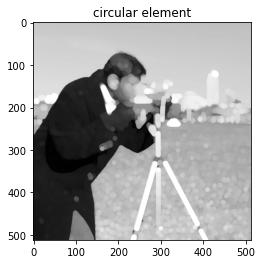

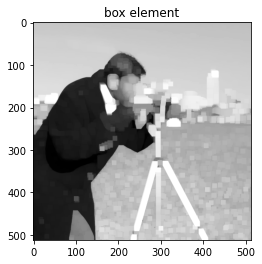

In [42]:
# Usar scipy.ndimage
from scipy import ndimage
se = circle(5)
im_circ = ndimage.grey_dilation(im_g, footprint = se)
#faster with boxlike se
im_box = ndimage.grey_dilation(im_g, size = se.shape)

plt.imshow(im_circ,'gray')
plt.title('circular element')
plt.show()

plt.imshow(im_box,'gray')
plt.title('box element')
plt.show()

# you can rewrite wrappers...
def im_dilate(im, se):
    if im.ndim == 3:
        return _morph_color(im, se, np.argmax)
    else:
        return ndimage.grey_dilation(im, footprint = se)
    
def im_erode(im, se):
    if im.ndim == 3:
        return _morph_color(im, se, np.argmin)
    else:
        return ndimage.grey_erosion(im, footprint = se)

### Bordes internos, externos y gradiente

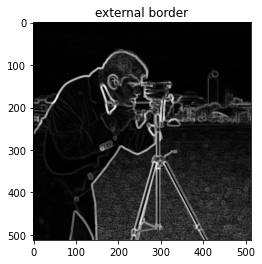

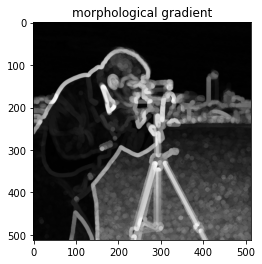

In [43]:
def im_border_ext(im, se):
    return im_dilate(im, se) - im

def im_border_int(im, se):
    return im - im_erode(im, se)

def im_gradient(im, se):
    return im_dilate(im,se) - im_erode(im,se)

plt.imshow(im_border_ext(im_g, se)/2+0.5,'gray')
plt.title('external border')
plt.show()

plt.imshow(im_gradient(im_g, se)/2+0.5,'gray')
plt.title('morphological gradient')
plt.show()

### Concatnación de dilatacion y erosión (apertura y cierre)

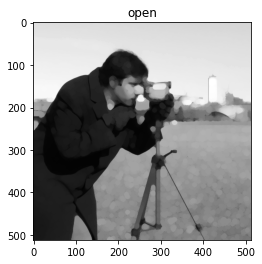

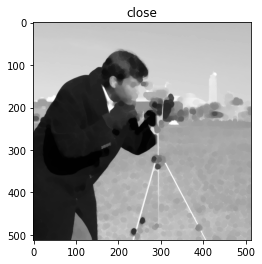

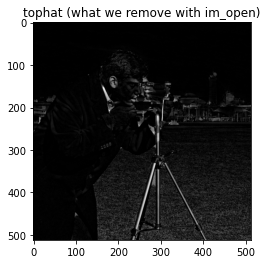

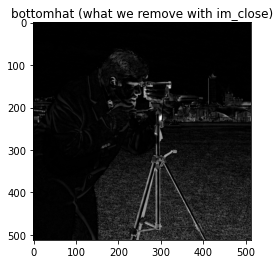

In [45]:
def im_open(im, se):
    return im_dilate(im_erode(im, se), se)

def im_close(im, se):
    return im_erode(im_dilate(im, se), se)

def im_tophat(im,se):
    return im - im_open(im,se)

def im_bottomhat(im,se):
    return im_close(im,se) - im

plt.imshow(im_open(im_g, se),'gray')
plt.title('open')
plt.show()

plt.imshow(im_close(im_g, se), 'gray')
plt.title('close')
plt.show()

plt.imshow(im_tophat(im_g, se),'gray')
plt.title('tophat (what we remove with im_open)')
plt.show()

plt.imshow(im_bottomhat(im_g, se), 'gray')
plt.title('bottomhat (what we remove with im_close)')
plt.show()